第5章 厳密解から近似解へ
==

$\mathbf{Ax}$と$\mathbf{b}$に少し差があっても許容するように$(P^{0})$ を考え直すことにする。ここでは許容誤差$\epsilon > 0$を用いて，問題$(P_{0})$の誤差を許容する変形版を次のように定義する．

$$ (P_{0}^{\epsilon}): \, \min_{x} \|x\|_{0} \text{ subject to } \|\mathbf{b} - \mathbf{Ax}\|_{2}^{2} \leq \epsilon$$

In [237]:
from matplotlib.font_manager import FontProperties

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

OMPによる$(P_{0}^{\epsilon})$の解法
--
停止条件を$\epsilon_{0}=\epsilon$とすれば，このアルゴリズムは制約条件$\|\mathbf{b}-\mathbf{Ax}\|_{2}\leq\epsilon$が満たされるまで解ベクトルの非ゼロ要素を積算することになる．修正はこのように軽微で済むので，OMPを実装し実行することは簡単で，広く使われている．

* $(P_{0})$の場合と特にアルゴリズムの変更はない

In [1]:
# 貪欲アルゴリズム
class Greedy(object):
    def __init__(self, A, b, eps=1e-4):
        """
        A m×n行列
        b n要素の観測
        eps 誤差の閾値
        """
        self.A = A
        self.b = b
        self.eps = eps

    def OMP(self):
        """ 直交マッチング追跡(orthogonal matching pursuit; OMP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in xrange(self.A.shape[1]):
            # 誤差計算
            err = rr - np.dot(self.A[:, S == 0].T, r) ** 2
            
            # サポート更新
            ndx = np.where(S == 0)[0]
            S[ndx[err.argmin()]] = 1
    
            # 解更新
            As = self.A[:, S == 1]
            pinv = np.linalg.pinv(np.dot(As, As.T))
            x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
            # 残差更新
            r = self.b - np.dot(self.A, x)
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S
    
    def MP(self):
        """ マッチング追跡(matching pursuit; MP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in xrange(1000):
            # 誤差計算
            err = rr - np.dot(self.A.T, r) ** 2

            # サポート更新
            j = err.argmin()
            S[j] = 1
    
            # 解更新
            a = self.A[:, j]
            z = np.dot(a, r)
            x[j] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def WMP(self, t=0.5):
        """ 
        弱マッチング追跡(weak matching pursuit; WMP)     
        t スカラー(0<t<1)
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in xrange(1000):
            # 誤差計算
            max_zz = 0
            j0 = 0
            for j in xrange(self.A.shape[1]):
                a = self.A[:, j]
                z = np.dot(a, r)
                if np.abs(z) > t * np.sqrt(rr):
                    j0 = j
                    break
                if z ** 2 > max_zz:
                    max_zz = z ** 2
                    j0 = j 
    
            # サポート更新
            S[j0] = 1
    
            # 解更新
            a = self.A[:, j0]
            z = np.dot(a, r)
            x[j0] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def Threshold(self, k):
        """ 
        閾値アルゴリズム(thresholding algorithm) 
        k 列の個数
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)

        # 誤差計算
        err = rr - np.dot(self.A.T, r) ** 2

        # サポートの更新
        ndx = np.argsort(err)[:k]
        S[ndx] = 1
        
        # 解更新
        As = self.A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
        return x, S

基底追跡ノイズ除去（basis pursuit denoising; BPDN）
--
$$ (P_{1}^{\epsilon}): \, \min_{x} \|x\|_{1} \text{ subject to } \|\mathbf{b}-\mathbf{Ax}\|_{2}$$

適切なラグランジュ乗数$\lambda$に対して，$(P_{1}^{\epsilon})$の解は，以下の制約なし最適化問題の解に一致する．

$$ (Q_{1}^{\lambda}): \, \min_{x} \lambda \|x\|_1 + \frac{1}{2} \|\mathbf{b} - \mathbf{Ax}\|^{2}_{2}$$

反復重み付け最小二乗法（IRLS）
--
* $(Q_{1}^{\lambda})$を解く単純な方法

$\mathbf{X} = \rm{diag}(|\mathbf{x}|)$とすると，$\|\mathbf{x}\|_{1} = \mathbf{x}^{T}\mathbf{X}^{-1}\mathbf{x}$である．つまり$\ell_{1}$ノルムは（重み付き）2乗$\ell_{2}$ノルムと見なすことができる．現在の近似界を$\mathbf{x}_{k_1}$が与えられたら，$\mathbf{X}_{k-1}=\rm{diag}(|\mathbf{x}_{k-1}|)$とおいて以下の問題を解く．

$$ (M_{k}):\, \min_{x} \lambda \mathbf{x}^{T}\mathbf{X}^{-1}_{k-1}\mathbf{x} + \frac{1}{2}\|\mathbf{b}-\mathbf{Ax}\|_{2}^{2}$$

* 思いつき：$\|\mathbf{x}\|_{0} = \mathbf{x}^{T}\mathbf{X}^{-2}\mathbf{x}$となる？

IRLSの具体例
--

In [2]:
# 数値例生成
class NumericalExample2(object):
    def __init__(self, n=100, m=200, k=4, sig=0.1):
        """ 
        n 行数
        m 列数
        k 非ゼロの要素数 
        A 冗長なシステム行列 mxn
        x スパースな解 m
        b ノイズを含む観測 n
        S サポート m
        """
        # 冗長なシステム行列A
        self.A = (np.random.rand(n, m) - 0.5) * 2
        self.A = np.dot(self.A, np.diag(1. / np.sqrt(np.diag(np.dot(self.A.T, self.A)))))    
        
        #　スパースなx
        self.x = np.zeros(m)
        ndx = np.random.randint(0, m - 1, k)
        for i in ndx:
            self.x[i] = np.random.rand() + 1.
            if np.random.rand() < 0.5:
                self.x[i] *= -1.

        # 雑音を含む観測n
        self.b = np.dot(self.A, self.x) + randn(n) * sig
        
        # サポートS
        self.S = np.zeros(m, dtype=np.uint8)
        self.S[ndx] = 1
        
        # 雑音の標準偏差
        self.sig = sig

In [184]:
from scipy.optimize import minimize

# 基底追跡ノイズ除去（basis pursuit denoising; BPDN）
class BPDN(object):
    def __init__(self, A, b, niter=1000):
        """
        A m×n行列
        b n要素の観測
        sig 雑音の標準偏差
        eps 誤差の閾値
        iter 反復回数
        """
        self.A = A
        self.b = b
        self.eps = 1e-3
        self.niter = niter
                
    def IRLS(self, lam=0.05):    
        """ 反復重み付け最小二乗(iterative-reweighted-least-squares; IRLS) """

        def f(x, *args):
            """ コスト関数 """
            lam, w, A, b = args
            reg = lam * np.dot(x.T, x / w) 
            err = b - np.dot(A, x)
            err2 = np.dot(err.T, err)
            return reg + 0.5 * err2

        # 初期化
        x = np.ones(self.A.shape[1])
        w = np.ones(self.A.shape[1])
        xs = []
        for i in xrange(self.niter):
            x_prev = x.copy()
            res = minimize(f, x, args=(lam, w, self.A, self.b))
            x = res.x
            xs.append(x)
            w = np.abs(x) + self.eps
            update = np.sum(np.abs(x - x_prev))
            if update < 1e-6:
                break
        
        # サポート
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        S[np.abs(x) > 0] = 1

        return x, S, xs

In [123]:
# 指標
def l2_err(x, x2):
    """ 正規化L2誤差 """
    return np.dot(x - x2, x - x2) / np.dot(x, x)

def dist_S(S, S2):
    """ サポート間距離 """
    val = max(np.sum(S), np.sum(S2))
    return float(val - np.sum(S * S2)) / val

def residual(A, x, b, sig):
    """ 残差とノイズパワーの比 """
    r = np.dot(A, x) - b 
    power = len(b) * (sig ** 2)
    return np.abs(np.log(np.dot(r, r) / power))

$\lambda$の値の決め方
--
* $(P_{0}^{\epsilon})$，$(P_{1}^{\epsilon})$では$\epsilon=\sqrt{n}\sigma$とすれば良い
* $(Q^{1}_{\lambda})$では$\lambda$の値が直感的に求まらない．
* 経験的には、$\sigma$と非ゼロ要素の標準偏差の比に近い値を$\lambda$とする．ここでは非ゼロ要素の標準偏差はおおよそ2なので，$\sigma/2=0.05$付近の値を$\lambda$とする．

$\lambda$に対する正規化$\ell_{2}$誤差
--

In [188]:
ne2 = NumericalExample2()

bpdn = BPDN(ne2.A, ne2.b, niter=100)
lams = np.logspace(-4, 0.5, 100)
errs = []
ress = []
x_lams = []
for i, lam in enumerate(lams):
    x_IRLS, S_IRLS, xs = bpdn.IRLS(lam=lam)
    err = l2_err(ne2.x, x_IRLS)
    res = residual(ne2.A, x_IRLS, ne2.b, ne2.sig)
    print i, lam, err, res
    errs.append(err)
    ress.append(res)
    x_lams.append(x_IRLS)
x_lams = np.array(x_lams)

0 0.0001 0.155651702041 11.64517735
1 0.000111033631817 0.155510116674 11.4360273207
2 0.000123284673944 0.155398168673 11.2212351385
3 0.000136887450954 0.154923245527 11.0171652167
4 0.000151991108295 0.154820420521 10.8126854896
5 0.000168761247579 0.154500307322 10.6041496149
6 0.000187381742286 0.154273618626 10.3949626399
7 0.000208056753822 0.154067757176 10.1886478285
8 0.000231012970008 0.153765268098 9.98372745626
9 0.000256502090568 0.153502929372 9.77297257562
10 0.000284803586844 0.153215966973 9.56792397412
11 0.000316227766017 0.152900619973 9.3599734787
12 0.000351119173422 0.152543467346 9.15259929784
13 0.000389860370255 0.152157496273 8.94391124754
14 0.000432876128108 0.151764460567 8.74046701986
15 0.000480638086306 0.151262495585 8.53262140726
16 0.000533669923121 0.150766261295 8.32613285135
17 0.000592553097555 0.150204861788 8.12168637525
18 0.000657933224658 0.149603993848 7.91634092167
19 0.000730527154266 0.148916504857 7.71095002974
20 0.00081113083079 0.14

破線は$\left|\log(\|\mathbf{A\hat{x}_{\lambda}}-\mathbf{b}\|)/(n\sigma^{2})\right|$の値を示しており，$\lambda$がどの値のときに残差$\|\mathbf{A\hat{x}_{\lambda}}-\mathbf{b}\|$がノイズパワー$n\sigma^{2}$と同程度になるのかを表している．これは$\lambda$の値を決める別の経験則であり，図からわかるように，このようにして$\lambda$を決めると最適解にかなり近づく．

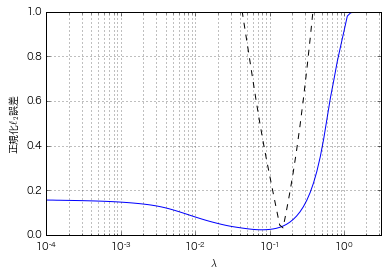

In [270]:
plt.semilogx(lams, errs)
plt.semilogx(lams, ress, '--k')
plt.xlim(lams[0], lams[-1])
plt.ylim(0, 1)
plt.grid(True, which="both")
plt.ylabel(u'正規化'+'$\ell_{2}$'+u'誤差')
plt.xlabel('$\lambda$')
plt.savefig('lambda.png', dpi=220)

最も良い$\lambda$の値を用いた場合と，それよりも大きい値と小さい値を用いた場合の，三つの解
--

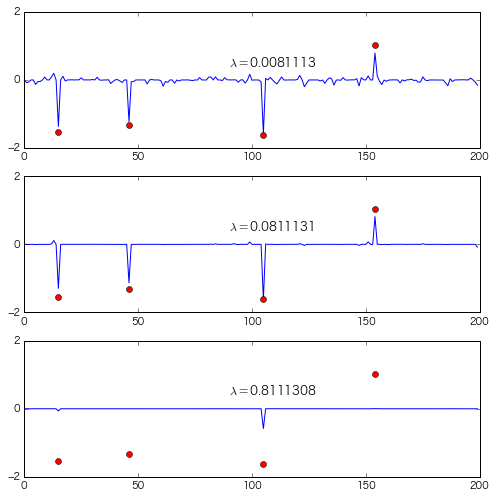

In [272]:
fig, ax = plt.subplots(3, 1, figsize=(7, 7))
ax = ax.flatten()
ndx = np.where(ne2.x != 0)[0]
for i, j in enumerate([42, 64, 86]):
    ax[i].plot(x_lams[j])
    ax[i].plot(ndx, ne2.x[ndx], 'ro')
    ax[i].set_yticks([-2, 0, 2])
    ax[i].text(90, 0.4, '$\lambda=${:.7f}'.format(lams[j]), fontsize=12)
plt.tight_layout()
plt.savefig('IRLS.png', dpi=220)

全ての$\lambda$に対するすべてのIRLSの解
--
各曲線は，$\lambda$の変化に伴って各要素の値が変化する経路を表している．破線は各$\mathbf{x}_{0}$の要素を表している．

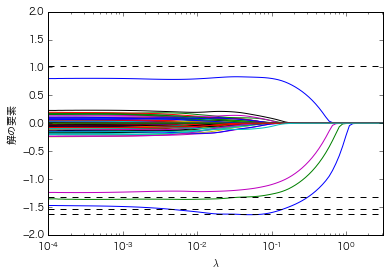

In [273]:
for pix in x_lams.T:
    plt.semilogx(lams, pix)
plt.xlim(lams[0], lams[-1])
plt.ylim(-2, 2)
ndx = np.where(ne2.x != 0)[0]
for col in ndx:
    plt.axhline(ne2.x[col], ls='--', c='k')
plt.ylabel(u'解の要素')
plt.xlabel('$\lambda$')
plt.savefig('path.png', dpi=220)

最適な$\lambda$を用いた場合の，IRLSの反復回数に対する関数値$\left(\lambda\|\mathbf{x}\|_{1}+\frac{1}{2}\|\mathbf{b}-\mathbf{Ax}\|_{2}^{2}\right)$
--
* IRLSで最小化する重み付きL2正則化項ではなくL1正則化項である点に注意

In [192]:
x_IRLS, S_IRLS, xs = bpdn.IRLS(lam=lams[64])

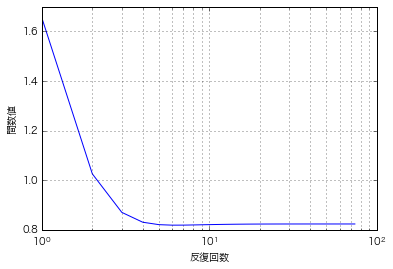

In [274]:
def f(A, b, x, lam):
    r = b - np.dot(A, x)
    return 0.5 * np.dot(r, r) + lam * np.sum(np.abs(x))

fs = []
for x in xs:
    fs.append(f(ne2.A, ne2.b, x, 0.09))
fs = np.array(fs)

plt.semilogx(np.arange(1, len(fs)+1), fs)
plt.grid(True, which='Both')
plt.ylabel(u'間数値')
plt.xlabel(u'反復回数')
plt.savefig('iteration.png', dpi=220)

In [266]:
from sklearn.linear_model import LassoLars

eps = np.sqrt(len(ne.b)) * 0.1

err_lars, err_omp, dist_lars, dist_omp = [], [], [], []
for k in xrange(1, 16):
    err, err2, dist, dist2 = 0, 0, 0, 0
    for _ in xrange(200):
        ne = NumericalExample2(n=30, m=50, k=k)
        
        lars = LassoLars(alpha=0.01)
        lars.fit(ne.A, ne.b)
        x_lars, S_lars = lars.coef_, np.where(lars.coef_ == 0, 0, 1)

        greedy = Greedy(ne.A, ne.b, eps=eps)
        x_OMP, S_OMP = greedy.OMP()
        
        err += l2_err(ne.x, x_lars)
        err2 += l2_err(ne.x, x_OMP)        
        dist += dist_S(ne.S, S_lars)
        dist2 += dist_S(ne.S, S_OMP)
    
    err /= 200
    err2 /= 200
    dist /= 200
    dist2 /= 200
    print err, err2, dist, dist2

    err_lars.append(err)
    err_omp.append(err2)
    dist_lars.append(dist)
    dist_omp.append(dist2)

0.051167351768 0.00551949196749 0.120416666667 0.0025
0.0640001565445 0.00476345995878 0.2185 0.005
0.0671305236641 0.00474889757365 0.232886904762 0.00375
0.0793078671837 0.00536864537412 0.270148809524 0.00733333333333
0.0983675519039 0.0263103933289 0.302224563835 0.0446994949495
0.119715835107 0.0515097824601 0.31378019203 0.0825683760684
0.165366985408 0.123296570579 0.373638950918 0.144441058941
0.188284626782 0.197493867314 0.379683128554 0.188640144578
0.236495649375 0.333787973061 0.407877910424 0.291407793595
0.258104524942 0.368091867576 0.405970786459 0.305488766136
0.310660508455 0.491574651977 0.415806464455 0.376231997578
0.364278067416 0.578191067902 0.434394076791 0.403269120865
0.394584244196 0.715296426831 0.422475719477 0.447155022931
0.397576167411 0.777512809881 0.417872442723 0.471048224587
0.454476780249 0.822825541537 0.435594178105 0.474792155299


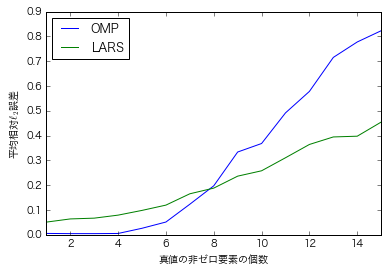

In [267]:
plt.plot(range(1, 16), err_omp, label='OMP')
plt.plot(range(1, 16), err_lars, label='LARS')
plt.ylabel(u'平均相対$\ell_2$誤差')
plt.xlabel(u'真値の非ゼロ要素の個数')
plt.legend(loc='best')
plt.xlim(1, 15)
plt.savefig('l2_err_OMP_LARS.png', dpi=220)

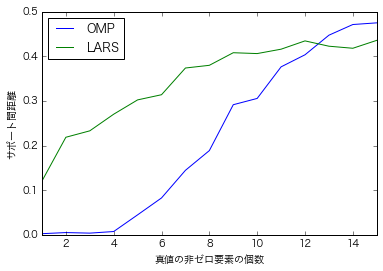

In [268]:
plt.plot(range(1, 16), dist_omp, label='OMP')
plt.plot(range(1, 16), dist_lars, label='LARS')
plt.ylabel(u'サポート間距離')
plt.xlabel(u'真値の非ゼロ要素の個数')
plt.legend(loc='best')
plt.xlim(1, 15)
plt.savefig('dist_S_OMP_LARS.png', dpi=220)